# Vehicle Routing Problem | ENGSCI 263

The Vehicle Routing Problem is a variation of the Travelling Salesperson problem, where a set of nodes each with a demand is given. The goal is to find a set of feasible routes such that demand at each node is satisfied at minimum cost.

The following notebook is a formulation of the Vehicle Routing Problem relating to Noel Leeming and Warehouse Stores across Auckland. The process goes as follows:

1. Data cleaning
2. Data exploration/visualisation
3. Calculation of deterministic demand estimates
4. Formulation of feasible routes
5. Formulate and solve the Linear Program
6. Repeat numbers 4 and 5 with inclusion of the northern distribution.
7. Simulation of optimal routes against probabilistic demand, and finding confidence intervals of the cost.
8. Significance of results
9. Visualisation of optimal rotues

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
from functions import *
import pulp
import scipy.stats as st
import statsmodels.stats.weightstats as sms
import folium
import openrouteservice as ors

## Data Cleaning and Exploration

In [3]:
demand_df = pd.read_csv('data/demandData.csv')
demand_df.head()

,Name,1/05/2023,2/05/2023,3/05/2023,4/05/2023,5/05/2023,6/05/2023,7/05/2023,8/05/2023,9/05/2023,...,19/05/2023,20/05/2023,21/05/2023,22/05/2023,23/05/2023,24/05/2023,25/05/2023,26/05/2023,27/05/2023,28/05/2023
0,Noel Leeming Albany,5,6,4,3,3,0,0,3,3,...,5,0,0,5,4,4,7,5,0,0
1,Noel Leeming Botany,3,4,7,3,8,0,0,6,6,...,5,0,0,6,4,3,5,7,0,0
2,Noel Leeming Henderson,3,6,5,4,5,0,0,4,3,...,6,0,0,2,6,5,3,7,0,0
3,Noel Leeming Lunn Avenue,2,4,5,5,2,0,0,4,6,...,4,0,0,4,3,4,4,4,0,0
4,Noel Leeming Manukau Supa Centre,4,7,5,4,3,0,0,5,3,...,5,0,0,5,8,2,3,4,0,0


Reshaped data, changed 'Date' column datatype to datetime, and added a new column 'Day of Week' where Monday = 0 and Sunday = 6

In [4]:
demand_df = pd.melt(demand_df, id_vars='Name', var_name='Date', value_name='Demand')
demand_df['Date'] = pd.to_datetime(demand_df['Date'], format='%d/%m/%Y', utc=True).dt.tz_convert('NZ')
demand_df.insert(demand_df.shape[1], 'Day of Week', demand_df['Date'].dt.dayofweek)
demand_df.head()

,Name,Date,Demand,Day of Week
0,Noel Leeming Albany,2023-05-01 12:00:00+12:00,5,0
1,Noel Leeming Botany,2023-05-01 12:00:00+12:00,3,0
2,Noel Leeming Henderson,2023-05-01 12:00:00+12:00,3,0
3,Noel Leeming Lunn Avenue,2023-05-01 12:00:00+12:00,2,0
4,Noel Leeming Manukau Supa Centre,2023-05-01 12:00:00+12:00,4,0


Filtered the demand dataframe to obtain a Noel Leeming dataframe

In [5]:
noel_leeming_df = demand_df.loc[demand_df['Name'].str.contains('Noel Leeming')]
noel_leeming_df.head()

,Name,Date,Demand,Day of Week
0,Noel Leeming Albany,2023-05-01 12:00:00+12:00,5,0
1,Noel Leeming Botany,2023-05-01 12:00:00+12:00,3,0
2,Noel Leeming Henderson,2023-05-01 12:00:00+12:00,3,0
3,Noel Leeming Lunn Avenue,2023-05-01 12:00:00+12:00,2,0
4,Noel Leeming Manukau Supa Centre,2023-05-01 12:00:00+12:00,4,0


Filtered the demand dataframe to obtain a Warehouse dataframe

In [6]:
warehouse_df = demand_df.loc[demand_df['Name'].str.contains('Warehouse')]
warehouse_df.head()

,Name,Date,Demand,Day of Week
15,The Warehouse Airport,2023-05-01 12:00:00+12:00,4,0
16,The Warehouse Albany,2023-05-01 12:00:00+12:00,5,0
17,The Warehouse Atrium,2023-05-01 12:00:00+12:00,7,0
18,The Warehouse Botany Downs,2023-05-01 12:00:00+12:00,7,0
19,The Warehouse Clendon,2023-05-01 12:00:00+12:00,6,0


Visualising demand for Noel Leeming stores for each day of the week:

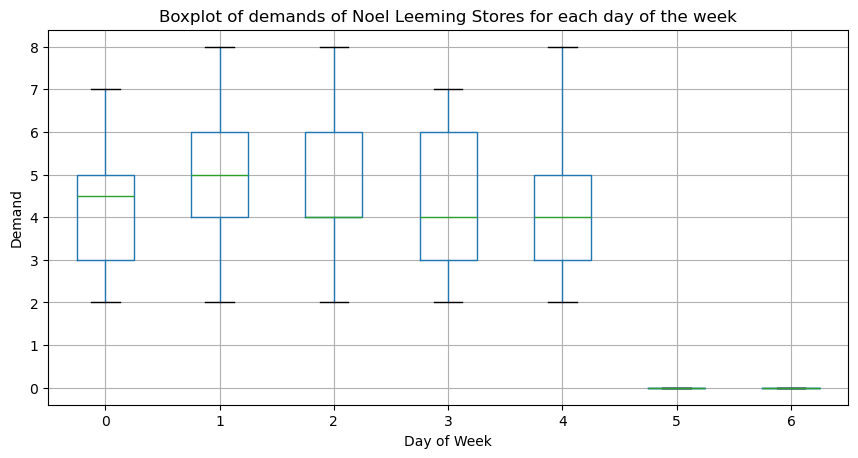

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
noel_leeming_df.boxplot(column='Demand', by='Day of Week', ax=ax)
plt.suptitle('')
ax.set_title('Boxplot of demands of Noel Leeming Stores for each day of the week')
ax.set_ylabel('Demand')
plt.show()

Generally, demand for Noel Leeming stores seem consistent on weekdays. Thus, one demand estimate will be used for Noel Leeming Stores.

Visualising demand for Warehouse stores for each day of the week:

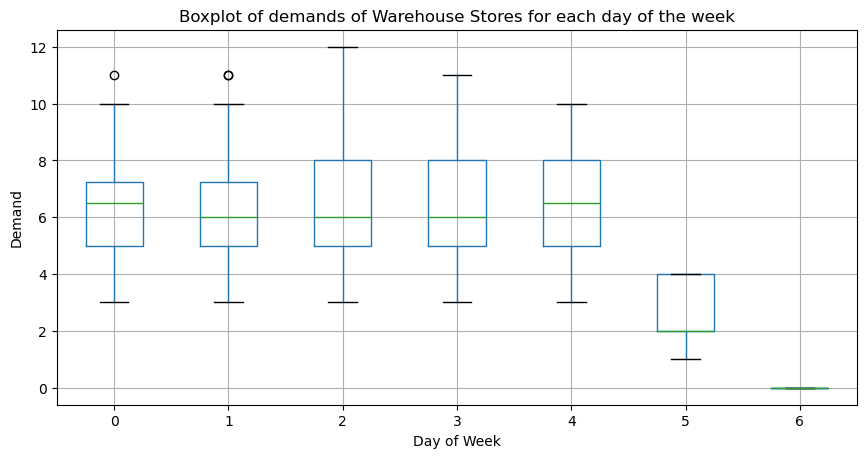

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
warehouse_df.boxplot(column='Demand', by='Day of Week', ax=ax)
plt.suptitle('')
ax.set_title('Boxplot of demands of Warehouse Stores for each day of the week')
ax.set_ylabel('Demand')
plt.show()

Generally demand for the Warehouse on each weekday is consistent, while demand on Saturday differs. Thus, for Warehouse stores, we will have two demand estiamtes - one for weekdays and one for Saturday

## Calculation of Demand Estimates

When calculating our deterministic demand estimates, we will use the upper 95% confidence interval in order to decrease the likelihood of stockouts

Calculating a deterministic demand estimate for the Warehouse stores on weekdays. 

In [9]:
mu = warehouse_df.loc[~warehouse_df['Day of Week'].isin([5, 6]), 'Demand'].mean()
std = warehouse_df.loc[~warehouse_df['Day of Week'].isin([5, 6]), 'Demand'].std()
n = warehouse_df.loc[~warehouse_df['Day of Week'].isin([5, 6]), 'Demand'].shape[0]
z = norm.ppf(q = 0.95)

warehouse_demand_weekday_estimate = math.ceil(mu + z * (std / math.sqrt(n)))
warehouse_demand_weekday_estimate

7

Calculating a deterministic demand estimate for the Warehouse stores on Saturdays:

In [10]:
mu = warehouse_df.loc[warehouse_df['Day of Week'] == 5, 'Demand'].mean()
std = warehouse_df.loc[warehouse_df['Day of Week'] == 5, 'Demand'].std()
n = warehouse_df.loc[warehouse_df['Day of Week'] == 5, 'Demand'].shape[0]

warehouse_demand_saturday_estimate = math.ceil(mu + z * (std / math.sqrt(n)))
warehouse_demand_saturday_estimate

3

Calculating a deterministic demand estimate for Noel Leeming Stores:

In [11]:
mu = noel_leeming_df.loc[~noel_leeming_df['Day of Week'].isin([5, 6]), 'Demand'].mean()
std = noel_leeming_df.loc[~noel_leeming_df['Day of Week'].isin([5, 6]), 'Demand'].std()
n = noel_leeming_df.loc[~noel_leeming_df['Day of Week'].isin([5, 6]), 'Demand'].shape[0]

noel_leeming_demand_estimate = math.ceil(mu + z * (std / math.sqrt(n)))
noel_leeming_demand_estimate

5

## Formulation of Feasible Routes

After calculating deterministic demand estimates, the next step involves using these estimates to formulate our VRP algorithm. We need to develop enough feasible routes so that our linear program solver can output a feasible (and hopefully good) solution. As enumerating through every combination of nodes is computationally expensive, we can instead divide Auckland into smaller regions, and enumerate through nodes within each region.

#### Region 1

Noel Leeming Papakura, Noel Leeming Manukau Supa Centre, Noel Leeming Papatoetoe, Noel Leeming Ormiston, Noel Leeming Botany, The Warehouse Takanini, The Warehouse Clendon, The Warehouse Manukau, The Warehouse Airport, The Warehouse Botany Downs.

#### Region 2

Noel Leeming Penrose Clearance, Noel Leeming Lunn Avenue, Noel Leeming Royal Oak, Noel Leeming Newmarket, Noel Leeming Sylvia Park, Noel Leeming St Lukes Mega, The Warehouse Pakuranga, The Warehouse Sylvia Park, The Warehouse Lunn Avenue, The Warehouse Royal Oak, The Warehouse Newmarket, The Warehouse St Lukes, The Warehouse Mt Roskill, The Warehouse Atrium.

#### Region 3

Noel Leeming New Lynn, Noel Leeming Henderson, The Warehouse New Lynn, The Warehouse WestCity, The Warehouse Lincoln Road, The Warehouse Westgate.

#### Region 4

Noel Leeming Wairau Park, Noel Leeming Albany, The Warehouse Milford, The Warehouse Glenfield Mall, The Warehouse Albany

In [12]:
weekday_region_1 = ['Noel Leeming Papakura', 'Noel Leeming Manukau Supa Centre', 'Noel Leeming Papatoetoe', 'Noel Leeming Ormiston', 'Noel Leeming Botany', 'The Warehouse Takanini', 'The Warehouse Clendon', 'The Warehouse Manukau', 'The Warehouse Airport', 'The Warehouse Botany Downs']
weekday_region_2 = ['Noel Leeming Penrose Clearance', 'Noel Leeming Lunn Avenue', 'Noel Leeming Royal Oak', 'Noel Leeming Newmarket', 'Noel Leeming Sylvia Park', 'Noel Leeming St Lukes Mega', 'The Warehouse Pakuranga', 'The Warehouse Sylvia Park', 'The Warehouse Lunn Avenue', 'The Warehouse Royal Oak', 'The Warehouse Newmarket', 'The Warehouse St Lukes', 'The Warehouse Mt Roskill', 'The Warehouse Atrium']
weekday_region_3 = ['Noel Leeming New Lynn', 'Noel Leeming Henderson', 'The Warehouse New Lynn', 'The Warehouse WestCity', 'The Warehouse Lincoln Road', 'The Warehouse Westgate']
weekday_region_4 = ['Noel Leeming Wairau Park', 'Noel Leeming Albany', 'The Warehouse Milford', 'The Warehouse Glenfield Mall', 'The Warehouse Albany']

Cleaning the distances and durations dataframes:

In [13]:
distances_df = pd.read_csv('data/WarehouseDistances.csv')
durations_df = pd.read_csv('data/WarehouseDurations.csv')

distances_df.rename(columns={'Unnamed: 0':'Origin'}, inplace=True)
durations_df.rename(columns={'Unnamed: 0':'Origin'}, inplace=True)

distances_df = pd.melt(distances_df, id_vars='Origin', var_name='Destination', value_name='Distance')
durations_df = pd.melt(durations_df, id_vars='Origin', var_name='Destination', value_name='Duration')

distances_df.head()

,Origin,Destination,Distance
0,Distribution South,Distribution South,0.00
1,Distribution North,Distribution South,35439.31
2,The Warehouse Atrium,Distribution South,27766.46
3,The Warehouse Newmarket,Distribution South,24417.75
4,The Warehouse Royal Oak,Distribution South,15533.03


Generating feasible routes for weekdays

In [14]:
all_regions_weekday = [weekday_region_1, weekday_region_2, weekday_region_3, weekday_region_4]
# this will take a while!
weekday_routes = create_routes(all_regions_weekday, distances_df, durations_df, noel_leeming_demand_estimate, warehouse_demand_weekday_estimate, False)

In [15]:
weekday_routes.head()

,Route,Demand,Distance,Driving Duration,Region
0,[Noel Leeming Papakura],5,36239.42,3051.50,1
1,[Noel Leeming Manukau Supa Centre],5,9434.55,1267.51,1
2,[Noel Leeming Papatoetoe],5,14008.72,1636.13,1
3,[Noel Leeming Ormiston],5,21076.24,2418.34,1
4,[Noel Leeming Botany],5,26331.52,2952.62,1


Now to generate feasible weekend routes. Note that only the Warehouse stores are open during the weekends.

In [16]:
weekend_region_1 = ['The Warehouse Takanini', 'The Warehouse Clendon', 'The Warehouse Manukau', 'The Warehouse Airport', 'The Warehouse Botany Downs']
weekend_region_2 = ['The Warehouse Pakuranga', 'The Warehouse Sylvia Park', 'The Warehouse Lunn Avenue', 'The Warehouse Royal Oak', 'The Warehouse Newmarket', 'The Warehouse St Lukes', 'The Warehouse Mt Roskill', 'The Warehouse Atrium']
weekend_region_3 = ['The Warehouse New Lynn', 'The Warehouse WestCity', 'The Warehouse Lincoln Road', 'The Warehouse Westgate']
weekend_region_4 = ['The Warehouse Milford', 'The Warehouse Glenfield Mall', 'The Warehouse Albany']

In [17]:
all_regions_weekend = [weekend_region_1, weekend_region_2, weekend_region_3, weekend_region_4]
weekend_routes = create_routes(all_regions_weekend, distances_df, durations_df, noel_leeming_demand_estimate, warehouse_demand_saturday_estimate, False)

Finding the durations of each route with inclusion of unloading time

In [18]:
weekday_routes.insert(loc=len(weekday_routes.columns), column='Duration', value=(weekday_routes['Driving Duration'] + weekday_routes['Demand'] * 600))
weekend_routes.insert(loc=len(weekend_routes.columns), column='Duration', value=(weekend_routes['Driving Duration'] + weekend_routes['Demand'] * 600))

In [19]:
weekday_routes.head()

,Route,Demand,Distance,Driving Duration,Region,Duration
0,[Noel Leeming Papakura],5,36239.42,3051.50,1,6051.50
1,[Noel Leeming Manukau Supa Centre],5,9434.55,1267.51,1,4267.51
2,[Noel Leeming Papatoetoe],5,14008.72,1636.13,1,4636.13
3,[Noel Leeming Ormiston],5,21076.24,2418.34,1,5418.34
4,[Noel Leeming Botany],5,26331.52,2952.62,1,5952.62


Calculating the total cost of each route:

In [20]:
weekday_routes['Cost'] = np.where(weekday_routes['Duration'] <= (4 * 3600), (weekday_routes['Duration']/3600) * 175, 175 * 4 + ((weekday_routes['Duration']/3600) - 4) * 300)
weekend_routes['Cost'] = np.where(weekend_routes['Duration'] <= (4 * 3600), (weekend_routes['Duration']/3600) * 175, 175 * 4 + ((weekend_routes['Duration']/3600) - 4) * 300)
weekday_routes.head()

,Route,Demand,Distance,Driving Duration,Region,Duration,Cost
0,[Noel Leeming Papakura],5,36239.42,3051.50,1,6051.50,294.170139
1,[Noel Leeming Manukau Supa Centre],5,9434.55,1267.51,1,4267.51,207.448403
2,[Noel Leeming Papatoetoe],5,14008.72,1636.13,1,4636.13,225.367431
3,[Noel Leeming Ormiston],5,21076.24,2418.34,1,5418.34,263.391528
4,[Noel Leeming Botany],5,26331.52,2952.62,1,5952.62,289.363472


## Linear Program Formulation

Formulation of our linear program for both weekday and weekend models

In [21]:
weekday_model = pulp.LpProblem(name='VRP', sense=pulp.LpMinimize)
weekday_vars = pulp.LpVariable.dicts('Route', weekday_routes.index, 0, None, pulp.LpBinary)
weekday_model += (pulp.lpSum([weekday_vars[i] * weekday_routes.loc[i, 'Cost'] for i in weekday_routes.index]), 'Sum of transporting')

weekend_model = pulp.LpProblem(name='VRP_weekend', sense=pulp.LpMinimize)
weekend_vars = pulp.LpVariable.dicts('Route', weekend_routes.index, 0, None, pulp.LpBinary)
weekend_model += (pulp.lpSum([weekend_vars[i] * weekend_routes.loc[i, 'Cost'] for i in weekend_routes.index]), 'Sum of transporting')

weekday_all_regions = weekday_region_1 + weekday_region_2 + weekday_region_3 + weekday_region_4
weekend_all_regions = weekend_region_1 + weekend_region_2 + weekend_region_3 + weekend_region_4

for store in weekday_all_regions:
    weekday_model += lpSum(weekday_vars[i] for i in range(len(weekday_vars)) if store in weekday_routes.loc[i, 'Route']) == 1
    
for store in weekend_all_regions:
    weekend_model += lpSum(weekend_vars[i] for i in range(len(weekend_vars)) if store in weekend_routes.loc[i, 'Route']) == 1


Solving our linear program...

In [22]:
solver = pulp.PULP_CBC_CMD(msg=False)
weekday_model.solve(solver)
weekend_model.solve(solver)

print(f"Weekday Status: {pulp.LpStatus[weekday_model.status]}")
print(f"Weekend Status: {pulp.LpStatus[weekend_model.status]}")
print("Weekday Optimal value: ", pulp.value(weekday_model.objective))
print("Weekend Optimal Value: ", pulp.value(weekend_model.objective))

Weekday Status: Optimal
Weekend Status: Optimal
Weekday Optimal value:  9321.971597222222
Weekend Optimal Value:  3767.3202777777783


Optimal weekday routes:

In [23]:
weekday_res = [v.name for v in weekday_model.variables() if v.varValue == 1]
optimal_weekday_routes = []

for r in weekday_res:
    optimal_weekday_routes.append(int(r.replace('Route_', '')))
     
for index, value in weekday_routes.loc[optimal_weekday_routes, 'Route'].items():
    print(value)

['Noel Leeming Ormiston', 'Noel Leeming Botany', 'The Warehouse Botany Downs']
['The Warehouse Royal Oak', 'The Warehouse Atrium']
['Noel Leeming Penrose Clearance', 'Noel Leeming Lunn Avenue', 'The Warehouse Lunn Avenue']
['Noel Leeming Royal Oak', 'Noel Leeming Newmarket', 'The Warehouse Newmarket']
['Noel Leeming Sylvia Park', 'The Warehouse Pakuranga', 'The Warehouse Sylvia Park']
['Noel Leeming St Lukes Mega', 'The Warehouse St Lukes', 'The Warehouse Mt Roskill']
['Noel Leeming New Lynn', 'The Warehouse New Lynn', 'The Warehouse WestCity']
['Noel Leeming Henderson', 'The Warehouse Lincoln Road', 'The Warehouse Westgate']
['The Warehouse Milford', 'The Warehouse Glenfield Mall']
['Noel Leeming Wairau Park', 'Noel Leeming Albany', 'The Warehouse Albany']
['The Warehouse Airport']
['Noel Leeming Papakura', 'The Warehouse Takanini', 'The Warehouse Clendon']
['Noel Leeming Manukau Supa Centre', 'Noel Leeming Papatoetoe', 'The Warehouse Manukau']


Optimal weekend routes:

In [24]:
weekend_res = [v.name for v in weekend_model.variables() if v.varValue == 1]
optimal_weekend_routes = []

for r in weekend_res:
    optimal_weekend_routes.append(int(r.replace('Route_', '')))
    
for index, value in weekend_routes.loc[optimal_weekend_routes, 'Route'].items():
    print(value)


['The Warehouse Clendon', 'The Warehouse Airport']
['The Warehouse Pakuranga', 'The Warehouse Sylvia Park', 'The Warehouse Lunn Avenue', 'The Warehouse Atrium']
['The Warehouse Royal Oak', 'The Warehouse Newmarket', 'The Warehouse St Lukes', 'The Warehouse Mt Roskill']
['The Warehouse Takanini', 'The Warehouse Manukau', 'The Warehouse Botany Downs']
['The Warehouse New Lynn']
['The Warehouse WestCity', 'The Warehouse Lincoln Road', 'The Warehouse Westgate']
['The Warehouse Milford']
['The Warehouse Glenfield Mall', 'The Warehouse Albany']


## Consideration of the Northern Distribution

We will now consider if opening the Northern Diatribution is a viable option. All stores in regions 3 and 4 will start and end at the Northen Distribution

Formulation of all possible weekday routes with consideration of the Northern Distribution

In [25]:
# this will take a while!
weekday_routes_north_dist = create_routes(all_regions_weekday, distances_df, durations_df, noel_leeming_demand_estimate, warehouse_demand_weekday_estimate, True)

In [26]:
weekday_routes_north_dist.head()

,Route,Demand,Distance,Driving Duration,Region
0,[Noel Leeming Papakura],5,36239.42,3051.50,1
1,[Noel Leeming Manukau Supa Centre],5,9434.55,1267.51,1
2,[Noel Leeming Papatoetoe],5,14008.72,1636.13,1
3,[Noel Leeming Ormiston],5,21076.24,2418.34,1
4,[Noel Leeming Botany],5,26331.52,2952.62,1


Formulation of all possible weekend routes with consideration of the Northern Distribution

In [27]:
weekend_routes_north_dist = create_routes(all_regions_weekend, distances_df, durations_df, noel_leeming_demand_estimate, warehouse_demand_saturday_estimate, True)

In [28]:
weekend_routes_north_dist.head()

,Route,Demand,Distance,Driving Duration,Region
0,[The Warehouse Takanini],3,27886.84,2623.80,1
1,[The Warehouse Clendon],3,5745.84,736.80,1
2,[The Warehouse Manukau],3,9541.32,1170.61,1
3,[The Warehouse Airport],3,22209.76,2176.53,1
4,[The Warehouse Botany Downs],3,26531.75,2980.27,1


Calculation of distances, durations and costs for each of these routes

In [29]:
weekday_routes_north_dist.insert(loc=len(weekday_routes_north_dist.columns), column='Duration', value=(weekday_routes_north_dist['Driving Duration'] + weekday_routes_north_dist['Demand'] * 600))
weekend_routes_north_dist.insert(loc=len(weekend_routes_north_dist.columns), column='Duration', value=(weekend_routes_north_dist['Driving Duration'] + weekend_routes_north_dist['Demand'] * 600))
weekday_routes_north_dist['Cost'] = np.where(weekday_routes_north_dist['Duration'] <= (4 * 3600), (weekday_routes_north_dist['Duration']/3600) * 175, 175 * 4 + ((weekday_routes_north_dist['Duration']/3600) - 4) * 300)
weekend_routes_north_dist['Cost'] = np.where(weekend_routes_north_dist['Duration'] <= (4 * 3600), (weekend_routes_north_dist['Duration']/3600) * 175, 175 * 4 + ((weekend_routes_north_dist['Duration']/3600) - 4) * 300)

In [30]:
weekday_routes_north_dist.head()

,Route,Demand,Distance,Driving Duration,Region,Duration,Cost
0,[Noel Leeming Papakura],5,36239.42,3051.50,1,6051.50,294.170139
1,[Noel Leeming Manukau Supa Centre],5,9434.55,1267.51,1,4267.51,207.448403
2,[Noel Leeming Papatoetoe],5,14008.72,1636.13,1,4636.13,225.367431
3,[Noel Leeming Ormiston],5,21076.24,2418.34,1,5418.34,263.391528
4,[Noel Leeming Botany],5,26331.52,2952.62,1,5952.62,289.363472


In [31]:
weekend_routes_north_dist.head()

,Route,Demand,Distance,Driving Duration,Region,Duration,Cost
0,[The Warehouse Takanini],3,27886.84,2623.80,1,4423.80,215.045833
1,[The Warehouse Clendon],3,5745.84,736.80,1,2536.80,123.316667
2,[The Warehouse Manukau],3,9541.32,1170.61,1,2970.61,144.404653
3,[The Warehouse Airport],3,22209.76,2176.53,1,3976.53,193.303542
4,[The Warehouse Botany Downs],3,26531.75,2980.27,1,4780.27,232.374236


Now to formulate our linear program with inclusion of the potential Northern Distribution

In [32]:
weekday_model_north_dist = pulp.LpProblem(name='VRP', sense=pulp.LpMinimize)
weekday_vars_north_dist = pulp.LpVariable.dicts('Route', weekday_routes_north_dist.index, 0, None, pulp.LpBinary)
weekday_model_north_dist += (pulp.lpSum([weekday_vars_north_dist[i] * weekday_routes_north_dist.loc[i, 'Cost'] for i in weekday_routes_north_dist.index]), 'Sum of transporting')

weekend_model_north_dist = pulp.LpProblem(name='VRP_weekend', sense=pulp.LpMinimize)
weekend_vars_north_dist = pulp.LpVariable.dicts('Route', weekend_routes_north_dist.index, 0, None, pulp.LpBinary)
weekend_model_north_dist += (pulp.lpSum([weekend_vars_north_dist[i] * weekend_routes_north_dist.loc[i, 'Cost'] for i in weekend_routes_north_dist.index]), 'Sum of transporting')

for store in weekday_all_regions:
    weekday_model_north_dist += pulp.lpSum(weekday_vars_north_dist[i] for i in range(len(weekday_vars_north_dist)) if store in weekday_routes_north_dist.loc[i, 'Route']) == 1
    
for store in weekend_all_regions:
    weekend_model_north_dist += pulp.lpSum(weekend_vars_north_dist[i] for i in range(len(weekend_vars_north_dist)) if store in weekend_routes_north_dist.loc[i, 'Route']) == 1

Solving our linear program...

In [33]:
solver = pulp.PULP_CBC_CMD(msg=False)
weekday_model_north_dist.solve(solver)
weekend_model_north_dist.solve(solver)

print(f"Weekday Status: {pulp.LpStatus[weekday_model_north_dist.status]}")
print(f"Weekend Status: {pulp.LpStatus[weekend_model_north_dist.status]}")
print("Weekday Optimal value (Northern Dist): ", pulp.value(weekday_model_north_dist.objective))
print("Weekend Optimal Value (Northern Dist): ", pulp.value(weekend_model_north_dist.objective))

Weekday Status: Optimal
Weekend Status: Optimal
Weekday Optimal value (Northern Dist):  8588.637083333335
Weekend Optimal Value (Northern Dist):  3217.6554861111113


Our optimal weekday routes with inclusion of the Northern Distribution

In [34]:
weekday_res_north_dist = [v.name for v in weekday_model_north_dist.variables() if v.varValue == 1]
optimal_weekday_routes_north_dist = []

for r in weekday_res_north_dist:
    optimal_weekday_routes_north_dist.append(int(r.replace('Route_', '')))
     
for index, value in weekday_routes_north_dist.loc[optimal_weekday_routes_north_dist, 'Route'].items():
    print(value)

['Noel Leeming Ormiston', 'Noel Leeming Botany', 'The Warehouse Botany Downs']
['The Warehouse Royal Oak', 'The Warehouse Atrium']
['Noel Leeming Penrose Clearance', 'Noel Leeming Lunn Avenue', 'The Warehouse Lunn Avenue']
['Noel Leeming Royal Oak', 'Noel Leeming Newmarket', 'The Warehouse Newmarket']
['Noel Leeming Sylvia Park', 'The Warehouse Pakuranga', 'The Warehouse Sylvia Park']
['Noel Leeming St Lukes Mega', 'The Warehouse St Lukes', 'The Warehouse Mt Roskill']
['Noel Leeming New Lynn', 'The Warehouse New Lynn', 'The Warehouse WestCity']
['Noel Leeming Henderson', 'The Warehouse Lincoln Road', 'The Warehouse Westgate']
['The Warehouse Milford', 'The Warehouse Glenfield Mall']
['Noel Leeming Wairau Park', 'Noel Leeming Albany', 'The Warehouse Albany']
['The Warehouse Airport']
['Noel Leeming Papakura', 'The Warehouse Takanini', 'The Warehouse Clendon']
['Noel Leeming Manukau Supa Centre', 'Noel Leeming Papatoetoe', 'The Warehouse Manukau']


Our optimal weekend routes with inclusion of the Northern Distribution

In [35]:
weekend_res_north_dist = [v.name for v in weekend_model_north_dist.variables() if v.varValue == 1]
optimal_weekend_routes_north_dist = []

for r in weekend_res_north_dist:
    optimal_weekend_routes_north_dist.append(int(r.replace('Route_', '')))
    
for value in weekend_routes_north_dist.loc[optimal_weekend_routes_north_dist, 'Route']:
    print(value)

['The Warehouse Clendon', 'The Warehouse Airport']
['The Warehouse Pakuranga', 'The Warehouse Sylvia Park', 'The Warehouse Lunn Avenue', 'The Warehouse Atrium']
['The Warehouse Royal Oak', 'The Warehouse Newmarket', 'The Warehouse St Lukes', 'The Warehouse Mt Roskill']
['The Warehouse Takanini', 'The Warehouse Manukau', 'The Warehouse Botany Downs']
['The Warehouse Westgate']
['The Warehouse New Lynn', 'The Warehouse WestCity', 'The Warehouse Lincoln Road']
['The Warehouse Milford']
['The Warehouse Glenfield Mall', 'The Warehouse Albany']


### Effect of Probabilistic Demand on Optimal Routes

The optimal prices are based on deterministic demands and travel durations. Now we will consider these to be probabilistic so that we can obtain some confidence intervals for our optimal objective value

Distribution of Noel Leeming demands

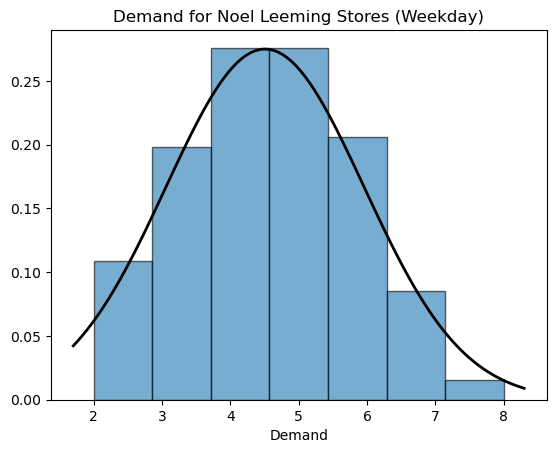

In [36]:
noel_leeming_demand = noel_leeming_df.loc[~noel_leeming_df['Day of Week'].isin([5, 6]), 'Demand']
nl_mu, nl_sd = norm.fit(noel_leeming_demand)
plt.hist(noel_leeming_demand, edgecolor='black', bins=7, density=True, alpha=0.6)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, nl_mu, nl_sd)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Demand for Noel Leeming Stores (Weekday)')
plt.xlabel('Demand')
plt.show()

Distribution of Warehouse demands on weekdays

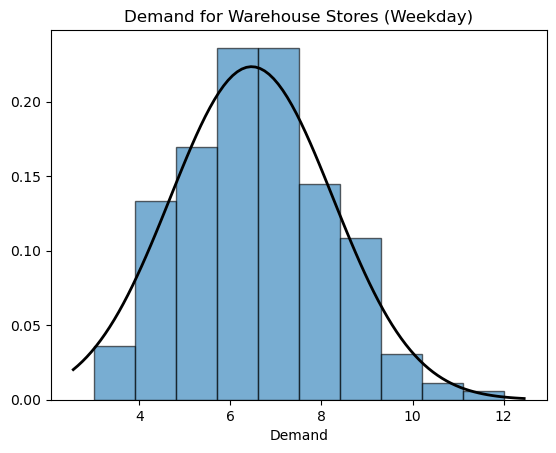

In [37]:
warehouse_demand = warehouse_df.loc[~warehouse_df['Day of Week'].isin([5, 6]), 'Demand']
warehouse_mu_weekday, warehouse_sd_weekday = norm.fit(warehouse_demand)
plt.hist(warehouse_demand, edgecolor='black', bins=10, density=True, alpha=0.6)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, warehouse_mu_weekday, warehouse_sd_weekday)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Demand for Warehouse Stores (Weekday)')
plt.xlabel('Demand')
plt.show()

Distribution of Warehouse demands on Saturdays

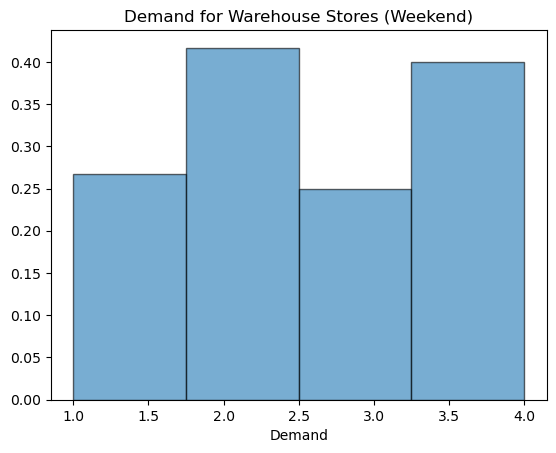

In [38]:
warehouse_weekend_demand = warehouse_df.loc[warehouse_df['Day of Week'].isin([5]), 'Demand']
warehouse_mu_weekend, warehouse_sd_weekend = norm.fit(warehouse_demand)
plt.hist(warehouse_weekend_demand, edgecolor='black', bins=4, density=True, alpha=0.6)
plt.title('Demand for Warehouse Stores (Weekend)')
plt.xlabel('Demand')
plt.show()

Both demand distributions for Noel Leeming and Warehouse appear to be normally distributed in the weekday. Thus it is appropriate to represent probabilistic demands by sampling from their respective distributions. The distribution of demands during the weekends for Warehouse stores is not clear - thus we will bootstrap these.

Transforming weekday routes into a nested list format

In [39]:
weekday_res = []
for value in weekday_routes.loc[optimal_weekday_routes, 'Route']:
    weekday_res.append(value)
    
weekday_res_regions = []
for value in weekday_routes.loc[optimal_weekday_routes, 'Region']:
    weekday_res_regions.append(value)

Simulation of Weekday routes under probabilistic demand

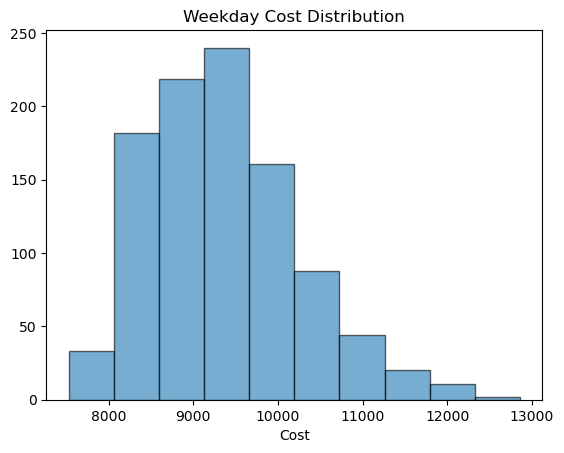

In [40]:
weekday_res = simulation(weekday_res, weekday_res_regions, durations_df, nl_mu, nl_sd, warehouse_mu_weekday, warehouse_sd_weekday, list(warehouse_weekend_demand), False, False, 1000)
plt.hist(weekday_res, edgecolor='black', alpha=0.6)
plt.xlabel('Cost')
plt.title('Weekday Cost Distribution')
plt.show()

95% confidence intervals for weekday cost per day

In [41]:
print('Weekday Costs 95% CI:', sms.DescrStatsW(weekday_res).tconfint_mean(alpha=0.05))

Weekday Costs 95% CI: (9310.296156956227, 9419.146718052334)


Transforming opitmal weekend routes into a nested list format

In [42]:
weekend_res = []
for value in weekend_routes.loc[optimal_weekend_routes, 'Route']:
    weekend_res.append(value)
    
weekend_res_regions = []
for value in weekend_routes.loc[optimal_weekend_routes, 'Region']:
    weekend_res_regions.append(value)

Simulation of optimal weekend routes under probabilistic demand

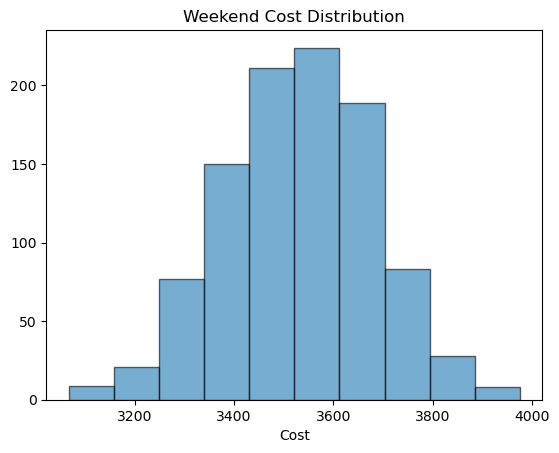

In [43]:
weekend_res = simulation(weekend_res, weekend_res_regions, durations_df, nl_mu, nl_sd, warehouse_mu_weekend, warehouse_sd_weekend, list(warehouse_weekend_demand), False, True, 1000)
plt.hist(weekend_res, edgecolor='black', alpha=0.6)
plt.title('Weekend Cost Distribution')
plt.xlabel('Cost')
plt.show()

95% confidence intervals for Saturday cost

In [44]:
print('Weekend Costs 95% CI:', sms.DescrStatsW(weekend_res).tconfint_mean(alpha=0.05))

Weekend Costs 95% CI: (3520.770153747845, 3538.896504585503)


Now to simulate with inclusion of the Northern Distribution...

In [45]:
weekday_res_north_dist = []
for value in weekday_routes_north_dist.loc[optimal_weekday_routes_north_dist, 'Route']:
    weekday_res_north_dist.append(value)

weekday_res_north_dist_regions = []
for value in weekday_routes_north_dist.loc[optimal_weekday_routes_north_dist, 'Region']:
    weekday_res_north_dist_regions.append(value)


Simulation of optimal weekday routes with inclusion of the northern distribution

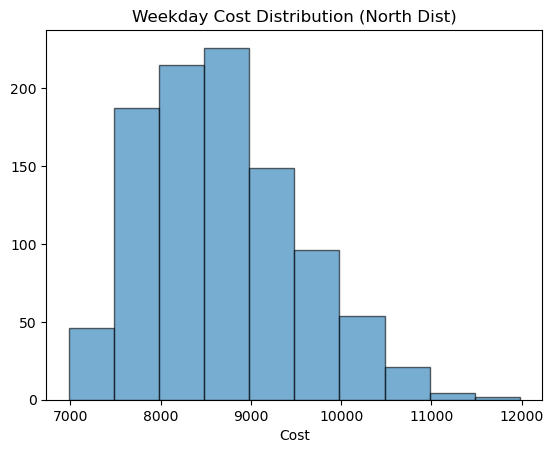

In [46]:
# this will take a while!
weekday_res_north_dist = simulation(weekday_res_north_dist, weekday_res_north_dist_regions, durations_df, nl_mu, nl_sd, warehouse_mu_weekday, warehouse_sd_weekday, list(warehouse_weekend_demand), True, False, 1000)
plt.hist(weekday_res_north_dist, edgecolor='black', alpha=0.6)
plt.xlabel('Cost')
plt.title('Weekday Cost Distribution (North Dist)')
plt.show()

95% confidence intervals for weekday costs per day with inclusion of the northern distribution

In [47]:
print('Weekday Costs 95% CI (Northern Distribution):', sms.DescrStatsW(weekday_res_north_dist).tconfint_mean(alpha=0.05))

Weekday Costs 95% CI (Northern Distribution): (8630.08992230408, 8733.298763502098)


Transformation of weekend optimal routes with inclusion of the northern distribution into a nested list format

In [48]:
weekend_res_north_dist = []
for index, value in weekend_routes_north_dist.loc[optimal_weekend_routes_north_dist, 'Route'].items():
    weekend_res_north_dist.append(value)

weekend_res_north_dist_regions = []
for value in weekend_routes_north_dist.loc[optimal_weekend_routes_north_dist, 'Region']:
    weekend_res_north_dist_regions.append(value)

Simulation of optimal weekend routes with inclusion of northern distribution under probabilistic demands

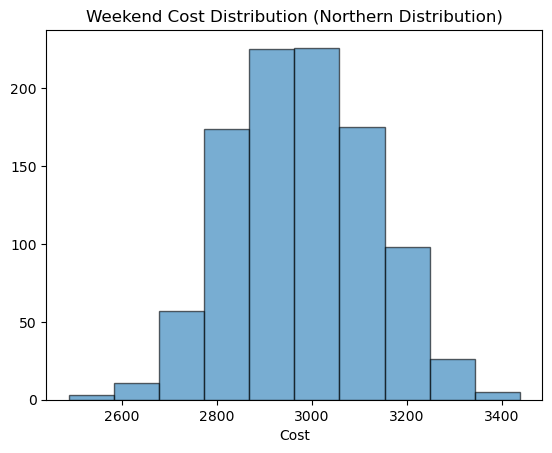

In [49]:
weekend_res_north_dist = simulation(weekend_res_north_dist,weekend_res_north_dist_regions, durations_df, nl_mu, nl_sd, warehouse_mu_weekend, warehouse_sd_weekend, list(warehouse_weekend_demand), True, True, 1000)
plt.hist(weekend_res_north_dist, edgecolor='black', alpha=0.6)
plt.title('Weekend Cost Distribution (Northern Distribution)')
plt.xlabel('Cost')
plt.show()

95% confidence intervals of Saturday cost with inclusion of the northern distribution

In [50]:
print('Weekend Costs 95% CI:', sms.DescrStatsW(weekend_res_north_dist).tconfint_mean(alpha=0.05))

Weekend Costs 95% CI: (2974.089877901427, 2992.0721970985787)


### Significance of Results

All four distributions are approximately normal. We will now perform a paired sample t-test to determine if the addition of the Northern distribution will have any **significant** change

In [51]:
st.ttest_rel(weekday_res, weekday_res_north_dist, alternative='greater')


TtestResult(statistic=17.736051210112887, pvalue=1.0617174222100387e-61, df=999)

We do the same with the weekend results...

In [52]:
st.ttest_rel(weekend_res, weekend_res_north_dist, alternative='greater')

TtestResult(statistic=86.0531368223087, pvalue=0.0, df=999)

At the 5% significant level (one-sided), the probability that we obtain a sample with mean greater than or equal to the one we have obtained (north distribution) is smaller than 0.05. Thus we reject $H_{0}$ that states there is no significant difference between the means for both weekday and weekend routing plans.

Therefore, we are confident that the inclusion of a Northern distribution has significant impact on the price of our vehicle routing plan.

### Mapping of Routes

We will now provied a visual represenation of the optimal routes obtained above...

In [53]:
ORSkey = '5b3ce3597851110001cf6248435b2e859bf9464180dde8823409a93e' 
locations_df = pd.read_csv('data/WarehouseLocations.csv')
locations_df.insert(locations_df.shape[1], column='Coordinates', value=locations_df[['Long', 'Lat']].to_numpy().tolist())
locations_df.head()

,Type,Location,Store,Long,Lat,Coordinates
0,Distribution,South,Distribution South,174.865463,-37.011888,"[174.8654634, -37.0118884]"
1,Distribution,North,Distribution North,174.758981,-36.802192,"[174.7589806, -36.8021921]"
2,The Warehouse,Atrium,The Warehouse Atrium,174.763875,-36.849776,"[174.7638746, -36.8497757]"
3,The Warehouse,Newmarket,The Warehouse Newmarket,174.779263,-36.865996,"[174.7792632, -36.8659962]"
4,The Warehouse,Royal Oak,The Warehouse Royal Oak,174.770076,-36.911970,"[174.7700757, -36.9119702]"


In [54]:
coords = locations_df[['Long', 'Lat']]
coords = coords.to_numpy().tolist()
m = folium.Map(location = list(reversed(coords[2])), zoom_start=10)

folium.Marker(list(reversed(coords[0])), popup = locations_df.Store[0], icon = folium.Icon(color = 'black')).add_to(m)

for i in range(1, len(coords)):
    if locations_df.Type[i] == "The Warehouse":
        iconCol = "red"
    elif locations_df.Type[i] == "Noel Leeming":
        iconCol = "orange"
    elif locations_df.Type[i] == "Distribution":
        iconCol = "black"
    folium.Marker(list(reversed(coords[i])), popup = locations_df.Store[i], icon = folium.Icon(color = iconCol)).add_to(m)

client = ors.Client(ORSkey)

is_north_dist = False # change this to view different map
is_weekend = False # change this to view different map

routes, optimal_routes, optimal_region = weekday_routes, optimal_weekday_routes, weekday_res_regions

if is_north_dist and is_weekend:
    routes, optimal_routes, optimal_region = weekend_routes_north_dist, optimal_weekend_routes_north_dist, weekend_res_north_dist_regions
elif is_north_dist and not is_weekend:
    routes, optimal_routes, optimal_region = weekday_routes_north_dist, optimal_weekday_routes_north_dist, weekday_res_north_dist_regions
elif not is_north_dist and is_weekend:
    routes, optimal_routes, optimal_region = weekend_routes, optimal_weekend_routes, weekend_res_regions

mapping(m, routes, optimal_routes, optimal_region, locations_df, client, is_north_dist)
display(m)
